In [1]:
import os
import time
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, kstest, boxcox, pointbiserialr
from itertools import product
from sklearn.decomposition import PCA
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import QuantileTransformer, OrdinalEncoder, LabelEncoder, StandardScaler

In [2]:
SEED = 1111116
RANDOM_STATE = 1111116
random.seed(SEED)
np.random.seed(SEED)

In [3]:
data_folder = "../data"

In [4]:
os.listdir(data_folder)

['sample_submission.csv',
 'test.csv',
 'test_encoded.csv',
 'test_encoded_scaled.csv',
 'train.csv',
 'train_encoded.csv',
 'train_encoded_scaled.csv']

In [5]:
df_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))

In [6]:
df_test.head(3)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0


### Domain knowledge

Prothrombin time:
A measure of how long it takes blood to clot. Liver disease can cause increased times, indicating poorer status.

Presence of edema:
N (no edema and no diuretic therapy for edema),
S (edema present without diuretics, or edema resolved by diuretics),
Y (edema despite diuretic therapy).
Swelling caused by excess fluid trapped in the body's tissues, often worsening the prognosis and indicating poorer status.

Histologic stage of disease (1, 2, 3, or 4):
the higher the stage, the more serious the condition.

Bilirubin:
A key blood marker indicating liver function
High levels can indicate liver dysfunction and may correlate with more advanced disease and poorer status.

cholesterol:
While not directly related to liver function, abnormal levels can be associated with certain liver conditions and overall health status.

Albumin:
Low levels can be a sign of liver disease and can indicate a poorer status due to the liver's reduced ability to synthesize proteins.

copper:
Elevated in certain liver diseases (like Wilson's disease), and could affect status if levels are abnormally high.

Alkaline phosphatase:
An enzyme related to the bile ducts; high levels might indicate blockage or other issues related to the liver.

SGOT:
An enzyme that, when elevated, can indicate liver damage and could correlate with a worsening status.	

Triglycerides:
Though mainly a cardiovascular risk indicator, they can be affected by liver function and, by extension, the status of the patient.

Platelets per cubic:
Low platelet count can be a result of advanced liver disease and can indicate a poorer status.

Normal range:
Bilirubin: 0.1 to 1.2 mg/dl
Cholesterol: 125 to 200 mg/dl
Albumin: 3.4 to 5.4 gm/dl
Copper: 10-30 ug/day
Alkaline Phosphatase: 40 to 129 U/litre.
SGOT: 8 to 45 U/L
Triglycerides: 48.68 to 168.15 mg/dL
Platelet: 150 to 400 unit
Prothrombin Time: 11 to 13.5 seconds.

### Columns of dataframes

In [7]:
df_train.columns.to_list()

['id',
 'N_Days',
 'Drug',
 'Age',
 'Sex',
 'Ascites',
 'Hepatomegaly',
 'Spiders',
 'Edema',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage',
 'Status']

### Shape of the dataframes

In [8]:
print("Shapes of df_train: ", df_train.shape)
print("Shapes of df_test: ", df_test.shape)

Shapes of df_train:  (7905, 20)
Shapes of df_test:  (5271, 19)


In [9]:
df_train["id"].isnull().any().any()

False

### Simple check for data leackage

In [10]:
print(df_train["id"].min())
print(df_train["id"].max())

0
7904


In [11]:
print(df_test["id"].min())
print(df_test["id"].max())

7905
13175


In [12]:
train_ids = df_train.id.to_list()
test_ids = df_test.id.to_list()

list(set(train_ids).intersection(test_ids)) 

[]

### Check for missing values

In [13]:
df_train.isnull().sum().sum()

0

In [14]:
df_test.isnull().sum().sum()

0

### Check for duplicates


In [15]:
df_duplicated = df_train[df_train.duplicated()]
df_duplicated.shape

(0, 20)

In [16]:
df_duplicated = df_test[df_test.duplicated()]
df_duplicated.shape

(0, 19)

### Features

In [17]:
Label = 'Status'
cat_feats = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage", "Status"]
num_feats = [col for col in df_train.columns if col not in cat_feats and col != Label and col != 'id']

In [18]:
num_feats

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin']

### Categorical features

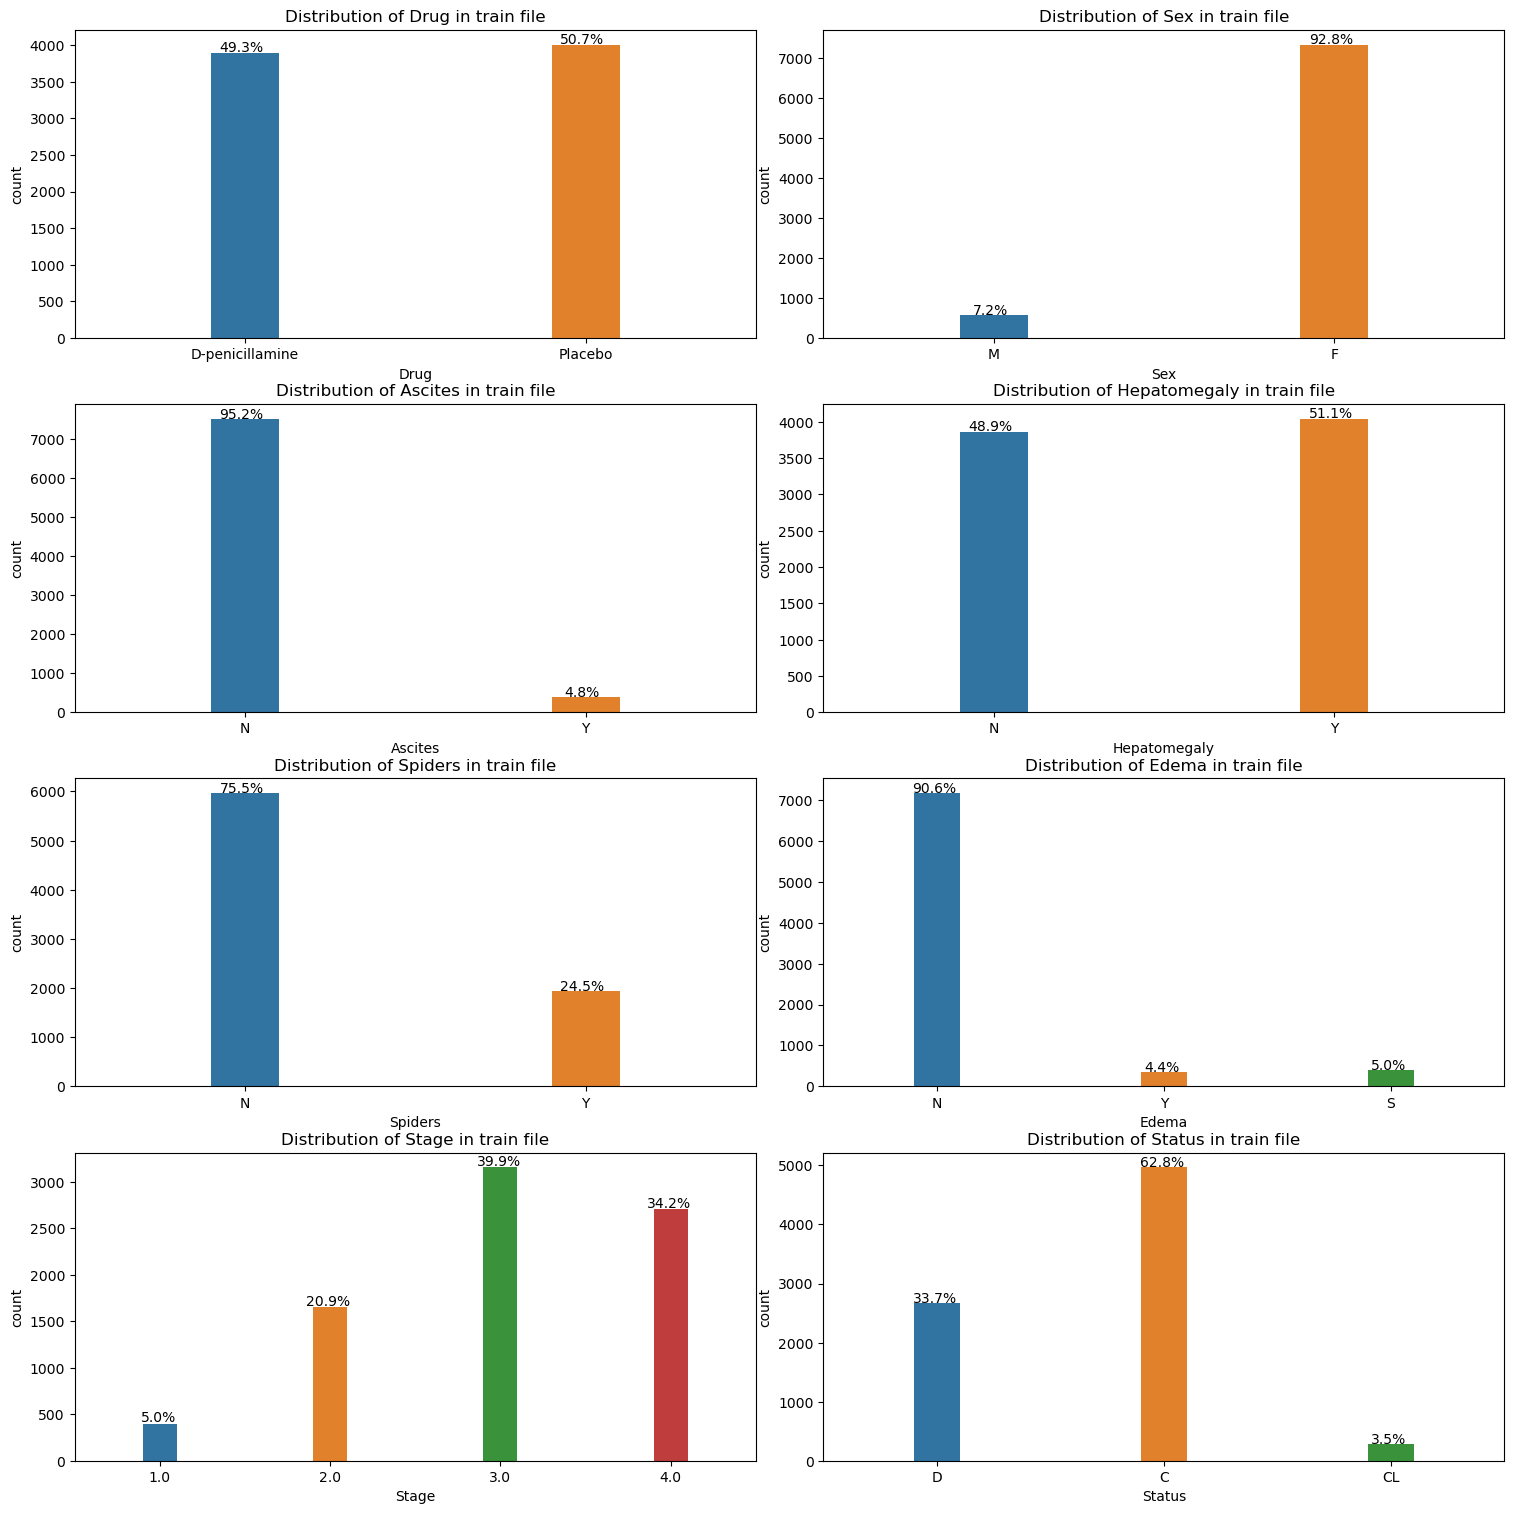

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = np.ravel(axes)

for i, col in enumerate(cat_feats):
    ax = sns.countplot(df_train, x=col, ax=axes[i], width=0.2)
    axes[i].set_title(f"Distribution of {col} in train file")

    total = len(df_train[col])

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.01
        y = p.get_height() + 20
        ax.annotate(percentage, (x, y), ha='center')

plt.tight_layout(pad=0.2)
plt.show()

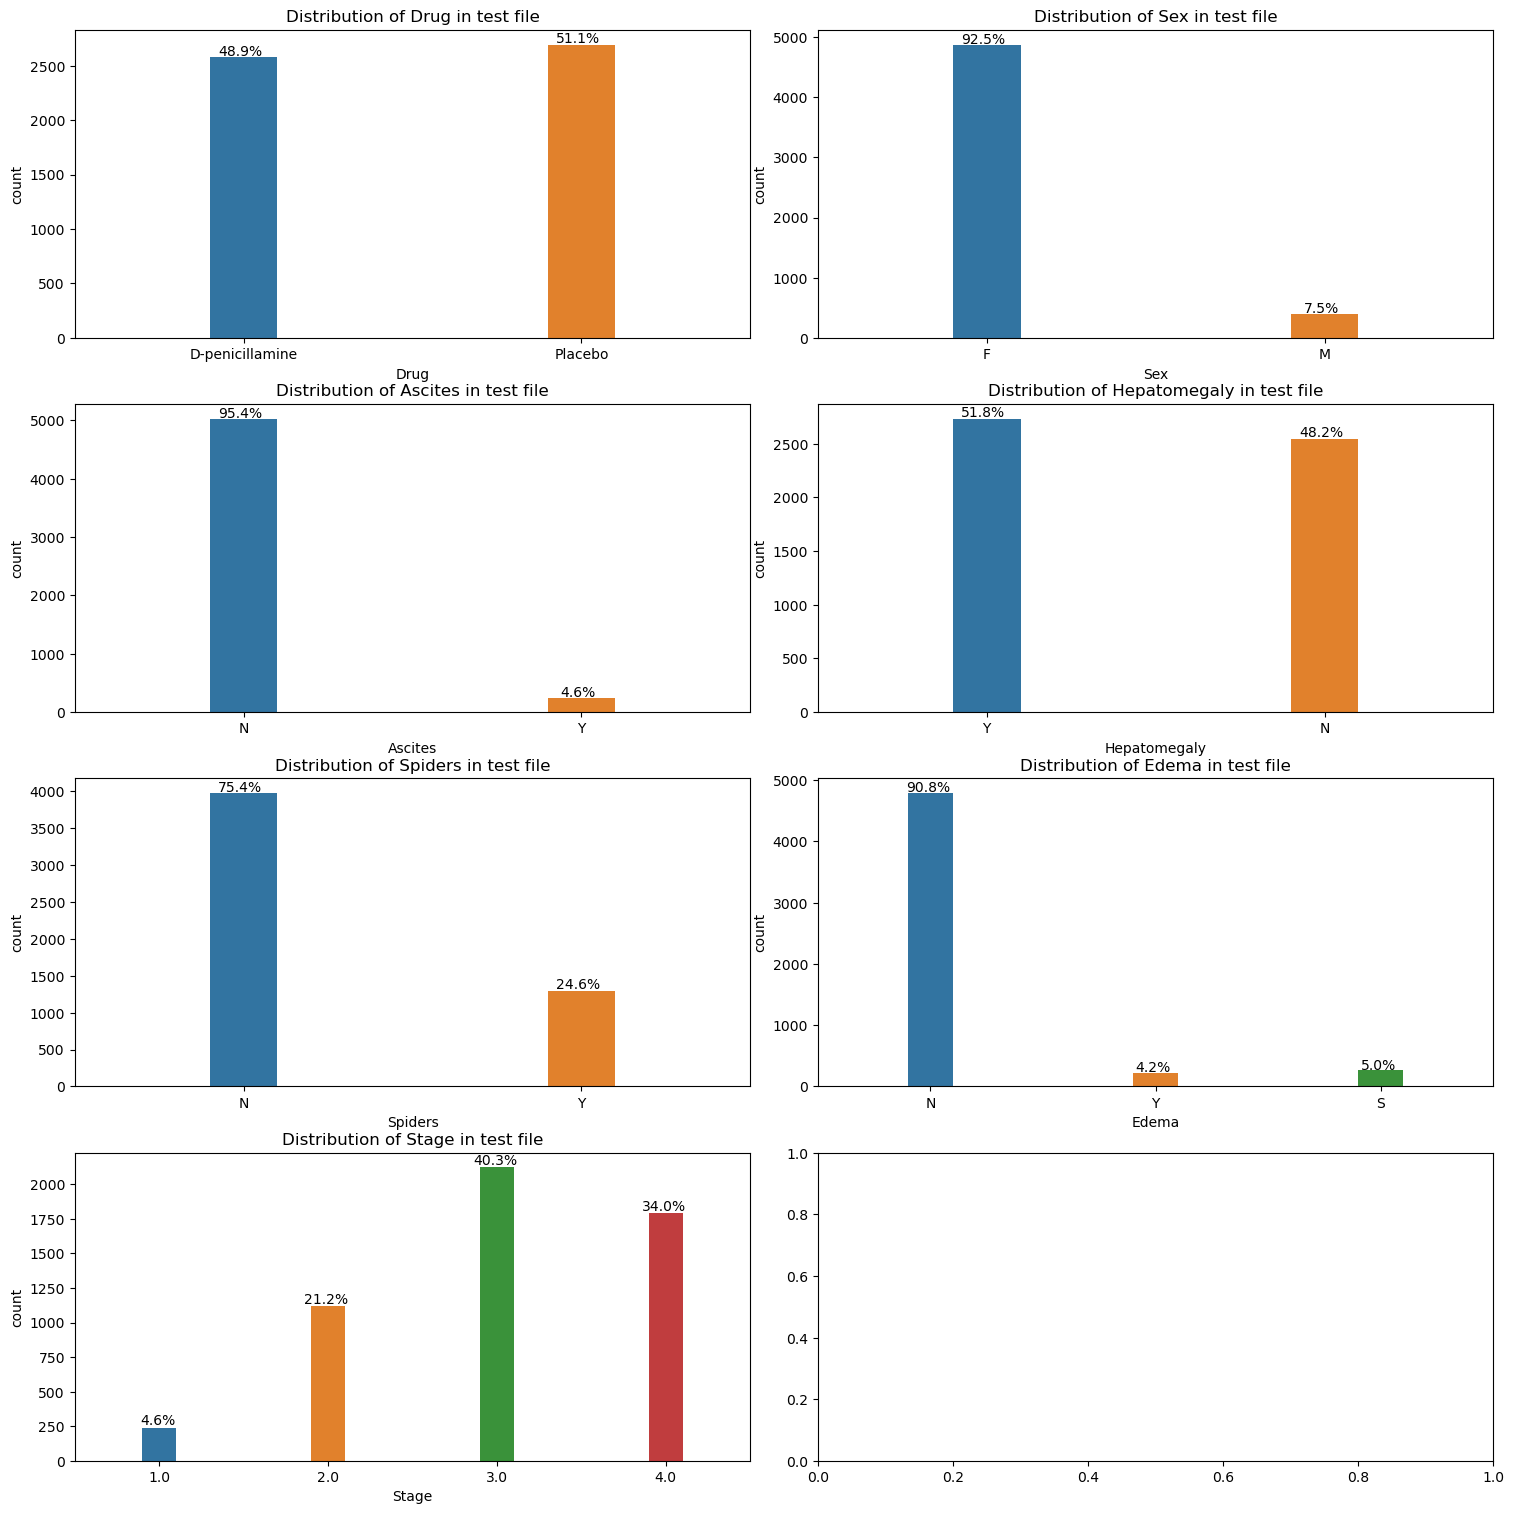

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = np.ravel(axes)

for i, col in enumerate(cat_feats):
    if col != "Status":
        ax = sns.countplot(df_test, x=col, ax=axes[i], width=0.2)
        axes[i].set_title(f"Distribution of {col} in test file")

        total = len(df_test[col])

        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.01
            y = p.get_height() + 20
            ax.annotate(percentage, (x, y), ha='center')

plt.tight_layout(pad=0.2)
plt.show()

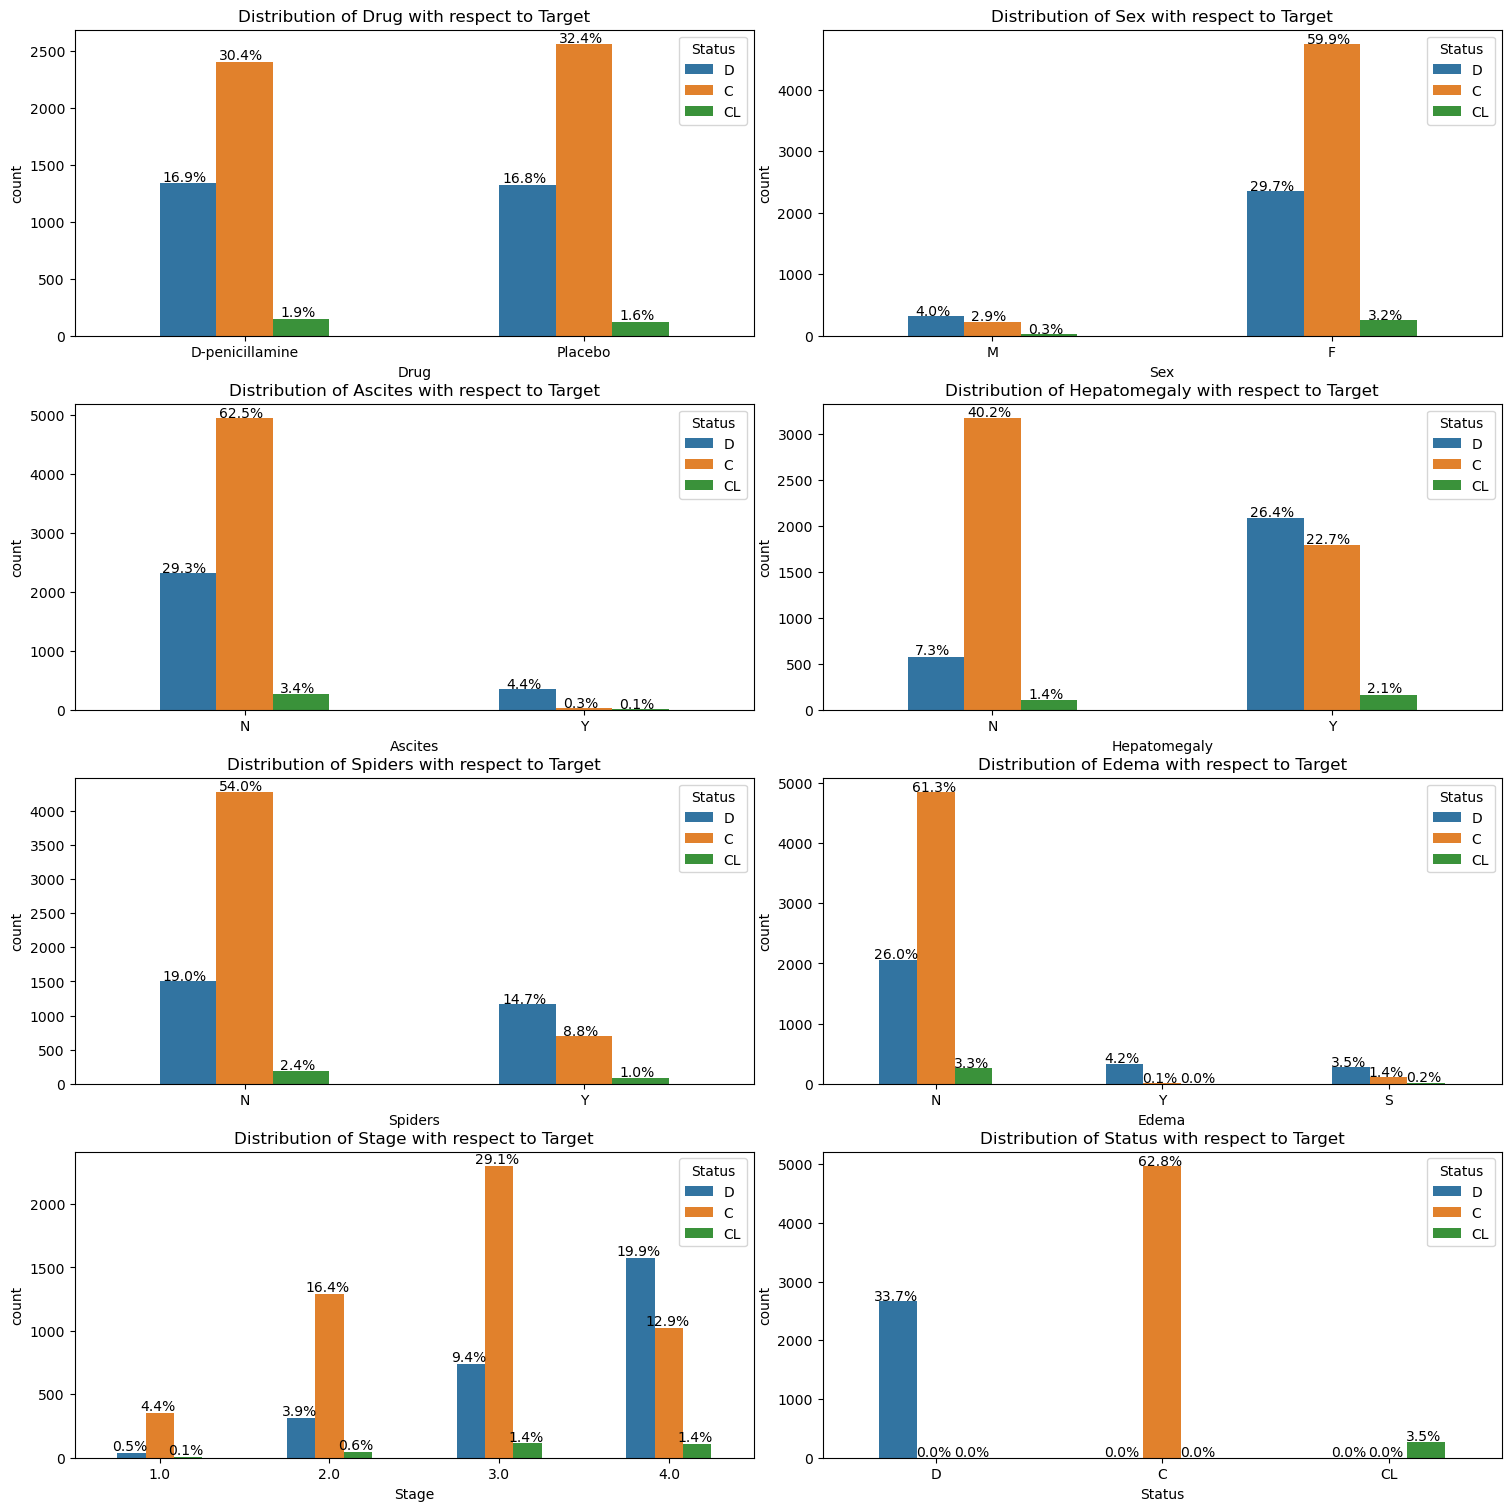

In [21]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = np.ravel(axes)

for i, col in enumerate(cat_feats):
    ax = sns.countplot(df_train, x=col, ax=axes[i], width=0.5, hue="Status")
    axes[i].set_title(f"Distribution of {col} with respect to Target")

    total = len(df_train[col])

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.01
        y = p.get_height() + 20
        ax.annotate(percentage, (x, y), ha='center')

plt.tight_layout(pad=0.3)
plt.show()

### Association between categorical features

Ho — There is no relationship between them

Ha — There is relationship between them

In [22]:
list_product_cat_feat = list(product(cat_feats, cat_feats))

In [23]:
for item in list_product_cat_feat:
    col1 = item[0]
    col2 = item[1]
    if col1 != col2:
        df_Cat_feat_corr = pd.crosstab(df_train[col1], df_train[col2])
        association_result = chi2_contingency(df_Cat_feat_corr)
        print(f"Association between {col1} and {col2}: ")
        print(f"statistic: {association_result[0]},  pvalue: {association_result[1]}, reject_H0: {'Y' if association_result[1] < 0.05 else 'N'}")
        print("*" * 50)

Association between Drug and Sex: 
statistic: 15.437711264606136,  pvalue: 8.526959229272763e-05, reject_H0: Y
**************************************************
Association between Drug and Ascites: 
statistic: 17.051178172564704,  pvalue: 3.638579311080764e-05, reject_H0: Y
**************************************************
Association between Drug and Hepatomegaly: 
statistic: 31.19386947544008,  pvalue: 2.335023238884784e-08, reject_H0: Y
**************************************************
Association between Drug and Spiders: 
statistic: 0.02634205224402115,  pvalue: 0.8710677655716053, reject_H0: N
**************************************************
Association between Drug and Edema: 
statistic: 10.462167097206013,  pvalue: 0.0053477276393892595, reject_H0: Y
**************************************************
Association between Drug and Stage: 
statistic: 8.565653346876157,  pvalue: 0.0356595003628192, reject_H0: Y
**************************************************
Association be

### Numerical features

In [24]:
df_train["Age"] = round(df_train["Age"] / 365)
df_test["Age"] = round(df_test["Age"] / 365)

In [25]:
df_train[num_feats].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
N_Days,7905.0,2030.173308,1094.233744,41.00,1230.00,1831.00,2689.00,4795.00
Age,7905.0,50.345478,10.072947,26.00,43.00,51.00,57.00,78.00
Bilirubin,7905.0,2.594485,3.812960,0.30,0.70,1.10,3.00,28.00
Cholesterol,7905.0,350.561923,195.379344,120.00,248.00,298.00,390.00,1775.00
Albumin,7905.0,3.548323,0.346171,1.96,3.35,3.58,3.77,4.64
Copper,7905.0,83.902846,75.899266,4.00,39.00,63.00,102.00,588.00
Alk_Phos,7905.0,1816.745250,1903.750657,289.00,834.00,1181.00,1857.00,13862.40
SGOT,7905.0,114.604602,48.790945,26.35,75.95,108.50,137.95,457.25
Tryglicerides,7905.0,115.340164,52.530402,33.00,84.00,104.00,139.00,598.00
Platelets,7905.0,265.228969,87.465579,62.00,211.00,265.00,316.00,563.00


In [26]:
df_test[num_feats].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
N_Days,5271.0,2038.696642,1086.843490,41.00,1234.00,1882.00,2692.00,4795.00
Age,5271.0,50.679378,9.805046,26.00,43.00,52.00,57.00,78.00
Bilirubin,5271.0,2.600389,3.852395,0.30,0.70,1.10,3.00,28.00
Cholesterol,5271.0,352.486435,200.438989,120.00,248.00,299.00,390.00,1775.00
Albumin,5271.0,3.538071,0.354886,1.96,3.35,3.57,3.77,4.64
Copper,5271.0,84.701679,77.542064,4.00,39.00,65.00,102.00,588.00
Alk_Phos,5271.0,1811.233314,1935.351492,289.00,823.00,1142.00,1838.50,13862.40
SGOT,5271.0,113.587526,48.964789,26.35,75.00,106.95,137.95,457.25
Tryglicerides,5271.0,115.286094,52.602780,33.00,84.00,104.00,138.00,598.00
Platelets,5271.0,264.023715,87.584068,62.00,209.00,259.00,317.00,563.00


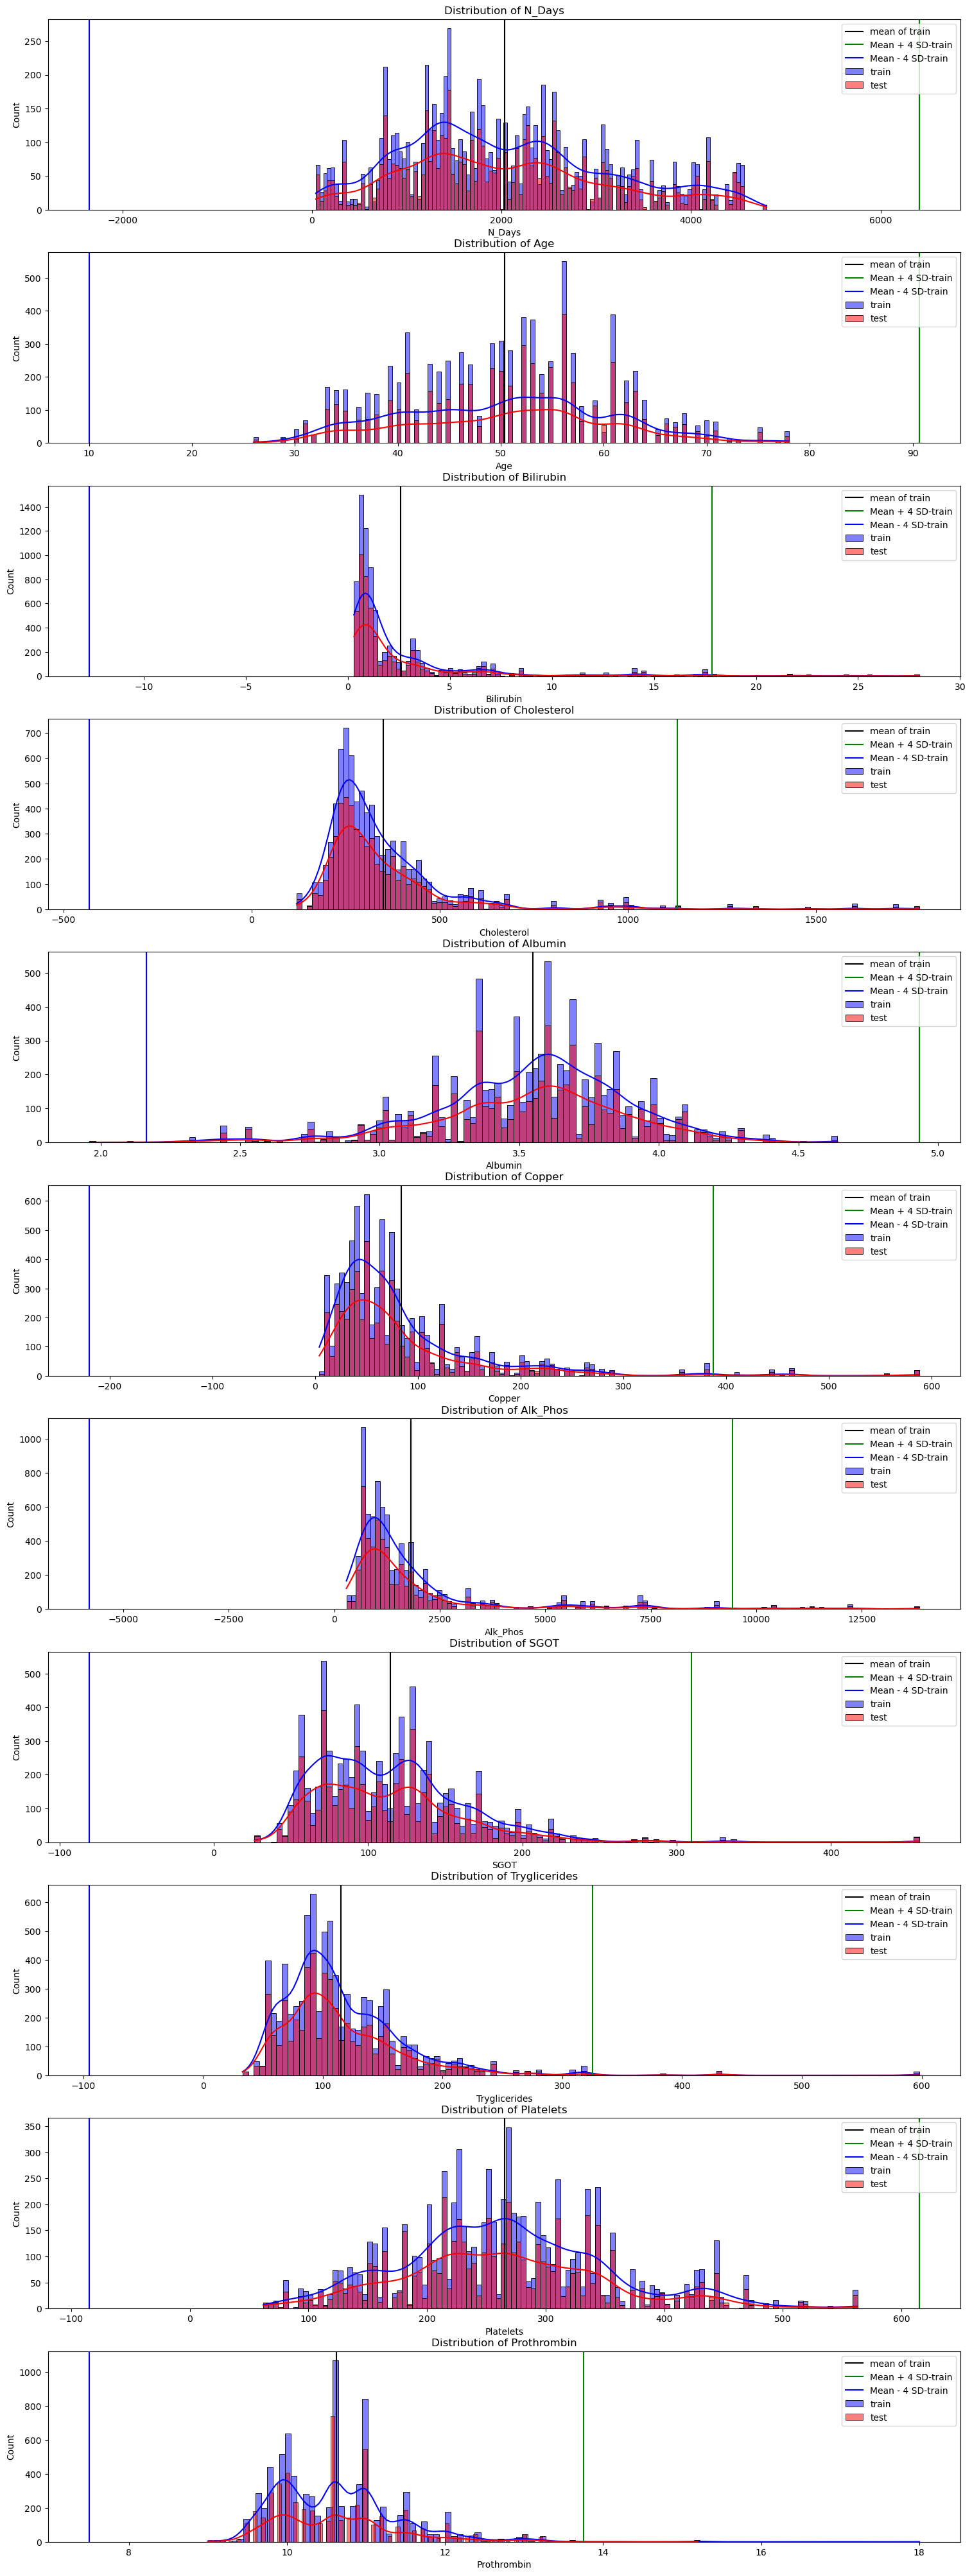

In [27]:
fig, axes = plt.subplots(11, 1, figsize =(15,40))
axes = np.ravel(axes)
for i, col in enumerate(num_feats):
    sns.histplot(df_train, x=col, ax=axes[i], kde=True, bins=120, color='blue', label = "train")
    sns.histplot(df_test, x=col, ax=axes[i], kde=True, bins=120, color='red', label = "test")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].axvline(df_train[col].mean(), color='black', label="mean of train")
    axes[i].axvline(df_train[col].mean() + (4 * df_train[col].std()), color='green', label="Mean + 4 SD-train")
    axes[i].axvline(df_train[col].mean() - (4 * df_train[col].std()), color='blue', label="Mean - 4 SD-train")
    axes[i].legend(loc="upper right")
    
plt.tight_layout(pad = 0.2)
plt.show()

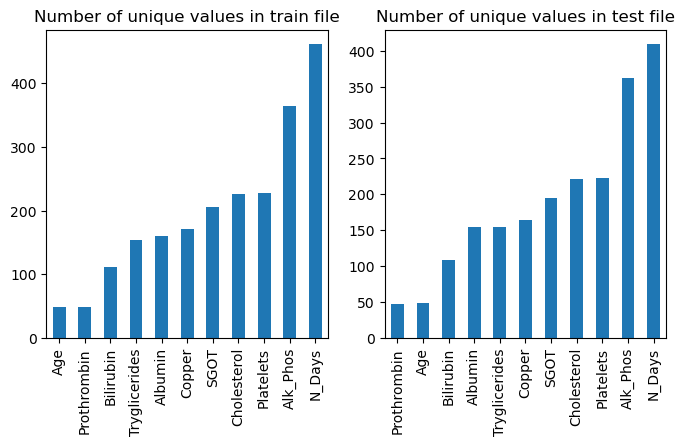

In [28]:
unique_values_train = df_train[num_feats].nunique().sort_values()
unique_values_test = df_test[num_feats].nunique().sort_values()

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
unique_values_train.plot.bar()
plt.title("Number of unique values in train file")
fig.add_subplot(122)
unique_values_test.plot.bar()
plt.title("Number of unique values in test file")

plt.show()

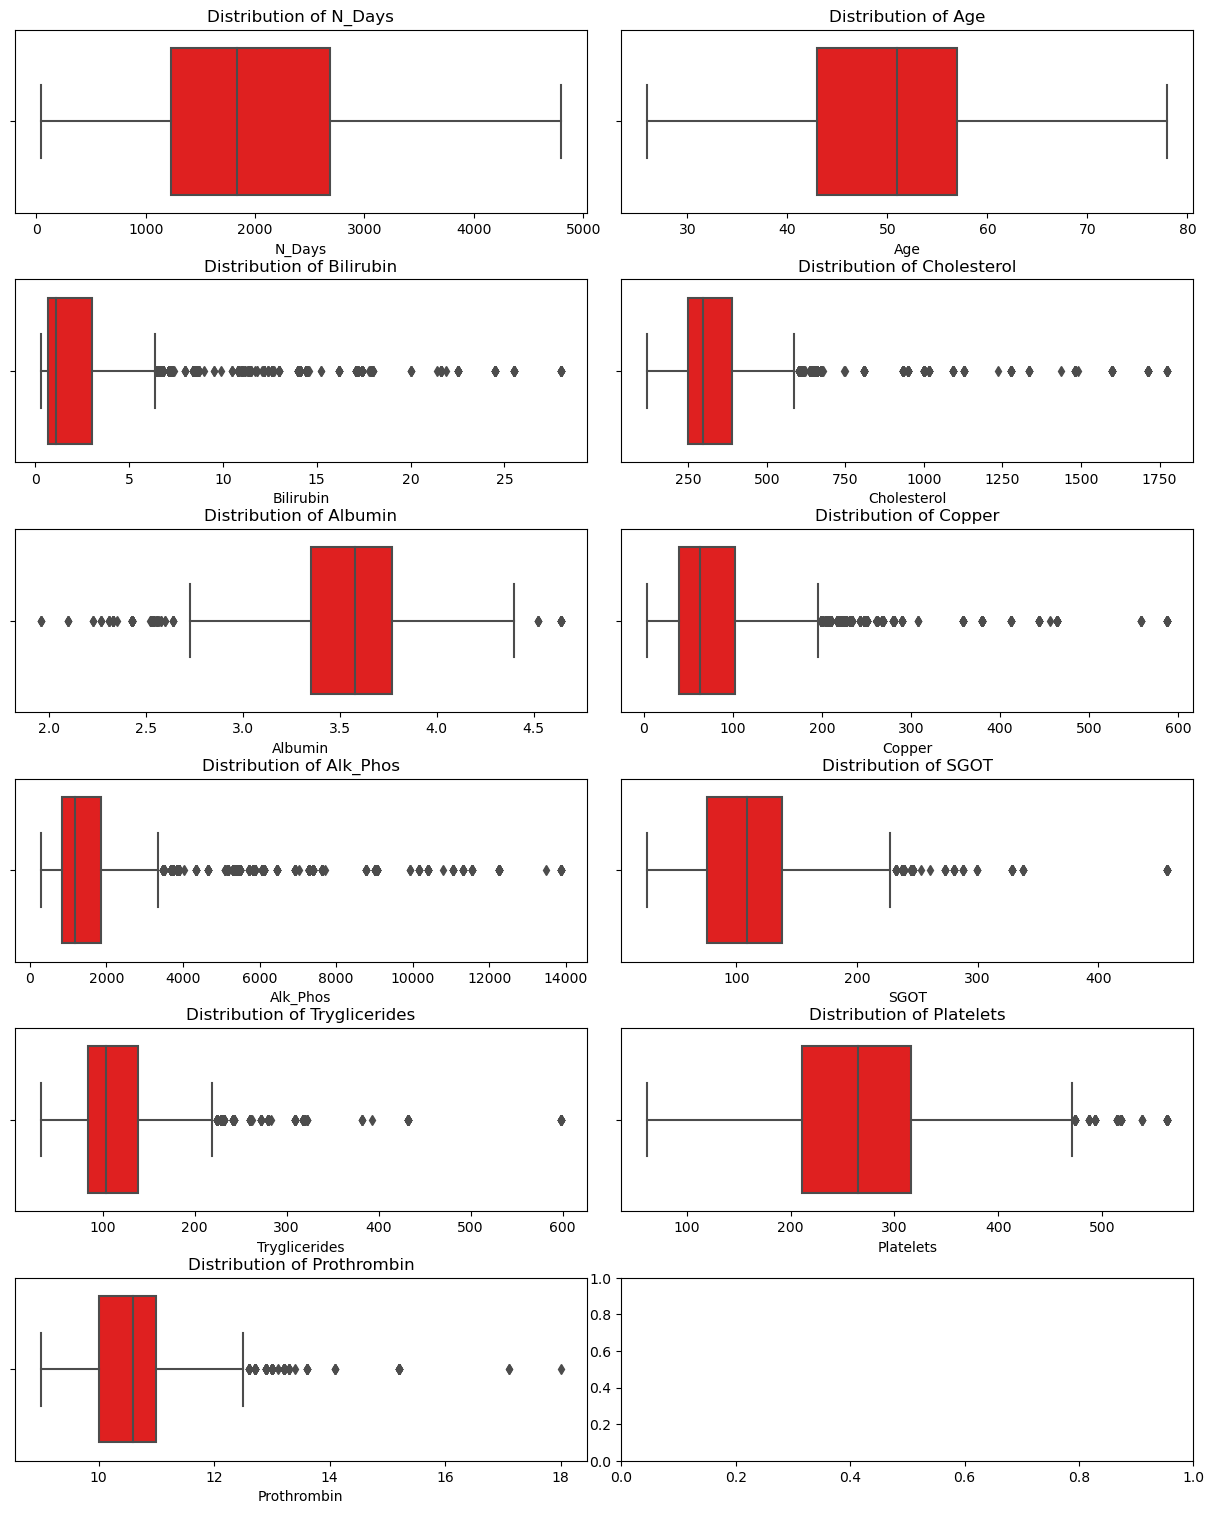

In [29]:
fig, axes = plt.subplots(6, 2, figsize =(12,15))
axes = np.ravel(axes)
for i, col in enumerate(num_feats):
    sns.boxplot(df_train, x=col, ax=axes[i], hue_order="Status", color="r")
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout(pad = 0.2)
plt.show()

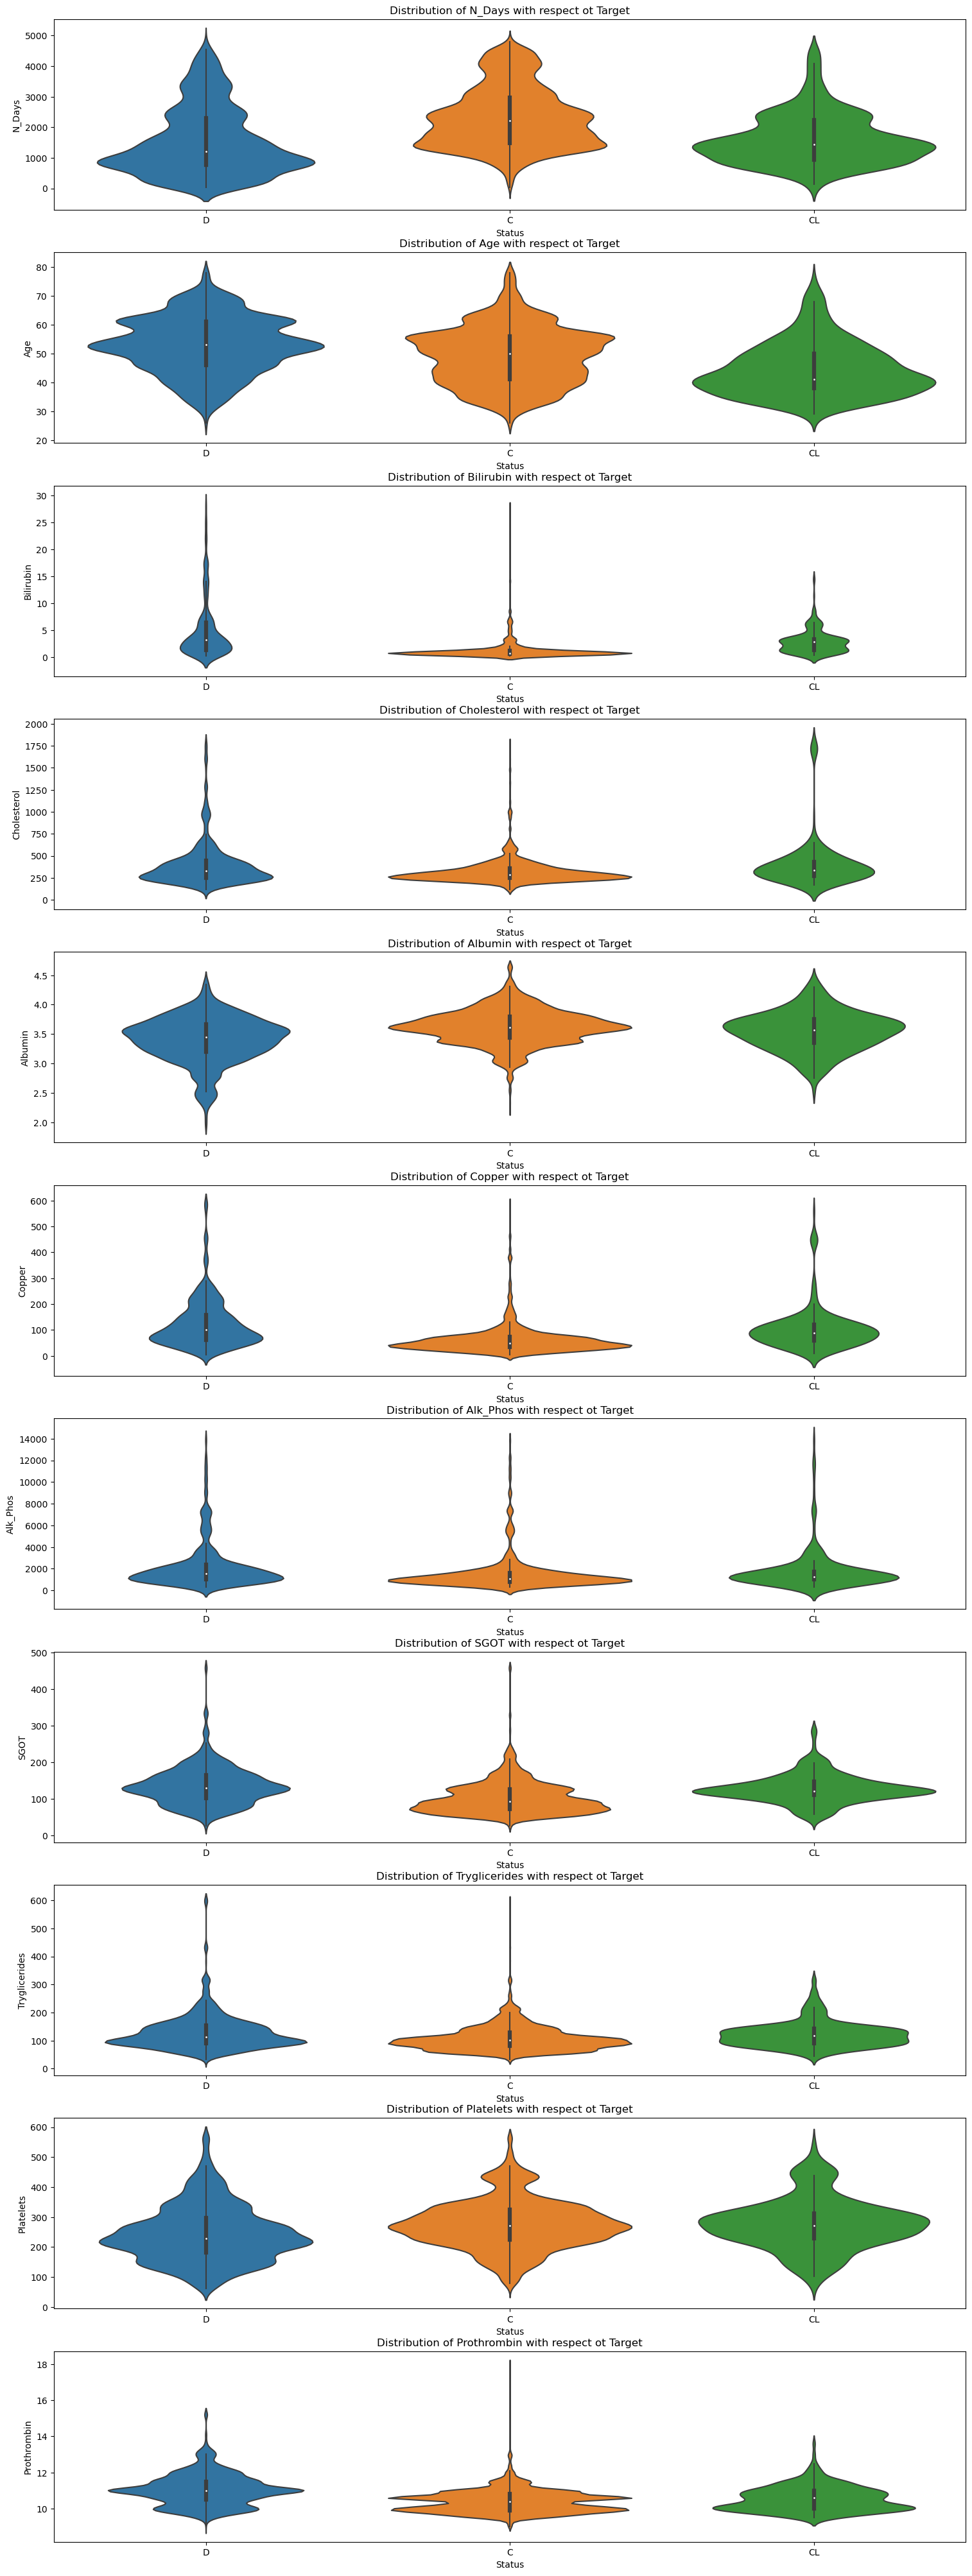

In [30]:
fig, axes = plt.subplots(11, 1, figsize =(15,40))
axes = np.ravel(axes)
for i, col in enumerate(num_feats):
    sns.violinplot(df_train, y=col, x='Status', ax=axes[i], )
    axes[i].set_title(f"Distribution of {col} with respect ot Target")
plt.tight_layout(pad = 0.2)
plt.show()

### Correlation between Numerical features

<Axes: >

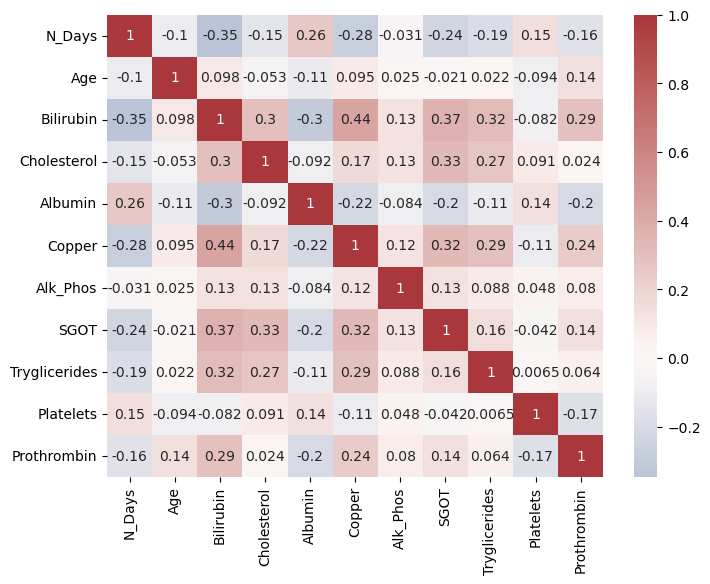

In [31]:
plt.figure(figsize=(8,6))
corr = df_train[num_feats].corr()
sns.heatmap(corr, annot=True,cmap="vlag", center=0)

### Transformation of numerical features and Normality tests

#### Ho — Not normal

#### Ha — Normal

In [32]:
cols_to_transform = ['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'Tryglicerides', 'SGOT']

#### Log Normal

In [33]:
df_transformed_log_normal = df_train[cols_to_transform].copy()

In [34]:
for col in cols_to_transform:
    test_result = kstest(df_transformed_log_normal[col], 'norm')
    print(f"{col}, statistic: {test_result[0]}, pvalue: {test_result[1]}, reject_H0: {'Y' if test_result[1] < 0.05 else 'N'}")
    print()

Bilirubin, statistic: 0.6621139476750252, pvalue: 0.0, reject_H0: Y

Cholesterol, statistic: 1.0, pvalue: 0.0, reject_H0: Y

Copper, statistic: 0.9999683287581669, pvalue: 0.0, reject_H0: Y

Alk_Phos, statistic: 1.0, pvalue: 0.0, reject_H0: Y

Tryglicerides, statistic: 1.0, pvalue: 0.0, reject_H0: Y

SGOT, statistic: 1.0, pvalue: 0.0, reject_H0: Y



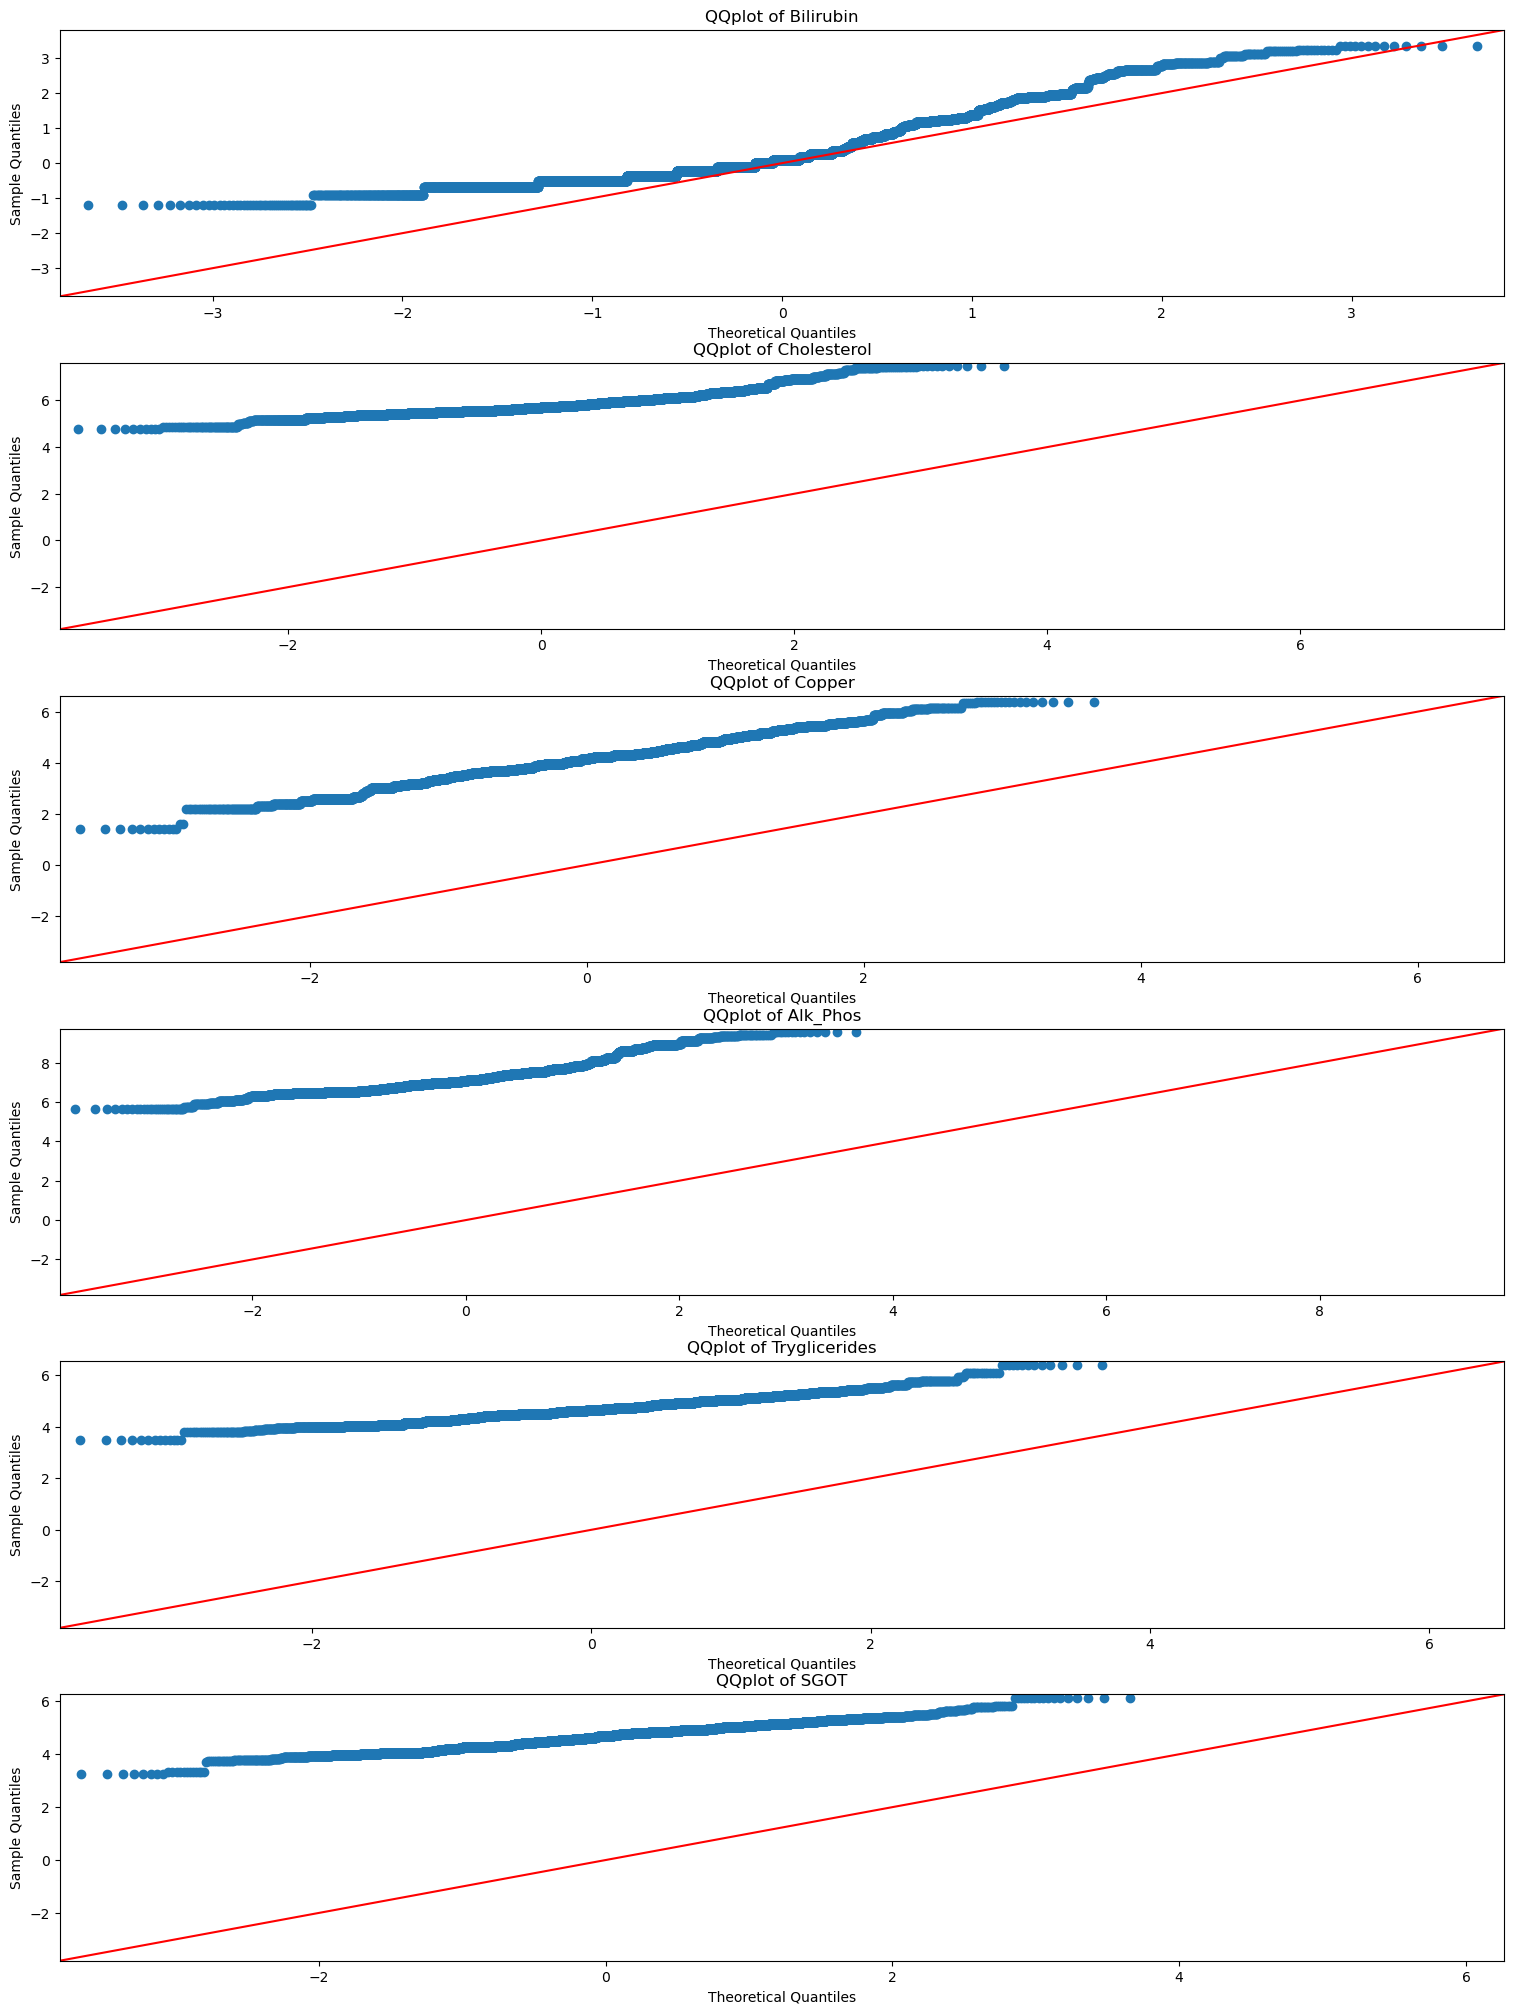

In [35]:
fig, axes = plt.subplots(6, 1, figsize =(15,20))
axes = np.ravel(axes)

for i, col in enumerate(df_transformed_log_normal.columns):
    df_transformed_log_normal[col] = np.log(df_transformed_log_normal[col] + 0.00001)
    qqplot(df_transformed_log_normal[col], line ='45', ax=axes[i])
    axes[i].set_title(f"QQplot of {col}")
plt.tight_layout(pad = 0.2)
plt.show()

#### QuantileTransformer

In [36]:
df_transformed_qualtile = df_train[cols_to_transform].copy()

In [37]:
scaler = QuantileTransformer(output_distribution="normal", n_quantiles=1000)
for i, col in enumerate(df_transformed_qualtile.columns):
    df_transformed_qualtile[col] = scaler.fit_transform(df_transformed_qualtile[col].values.reshape(-1,1))

In [38]:
for col in cols_to_transform:
    test_result = kstest(df_transformed_qualtile[col], 'norm')
    print(f"{col}, statistic: {test_result[0]}, pvalue: {test_result[1]}, reject_H0: {'Y' if test_result[1] < 0.05 else 'N'}")
    print()

Bilirubin, statistic: 0.05397541754277996, pvalue: 1.8594256357524707e-20, reject_H0: Y

Cholesterol, statistic: 0.009722815794922068, pvalue: 0.44086365833453567, reject_H0: N

Copper, statistic: 0.019857428586081416, pvalue: 0.003869527477707347, reject_H0: Y

Alk_Phos, statistic: 0.007575507196000669, pvalue: 0.7516958928452763, reject_H0: N

Tryglicerides, statistic: 0.016885196391837776, pvalue: 0.021799762330222395, reject_H0: Y

SGOT, statistic: 0.016299221422561072, pvalue: 0.029658381796820787, reject_H0: Y



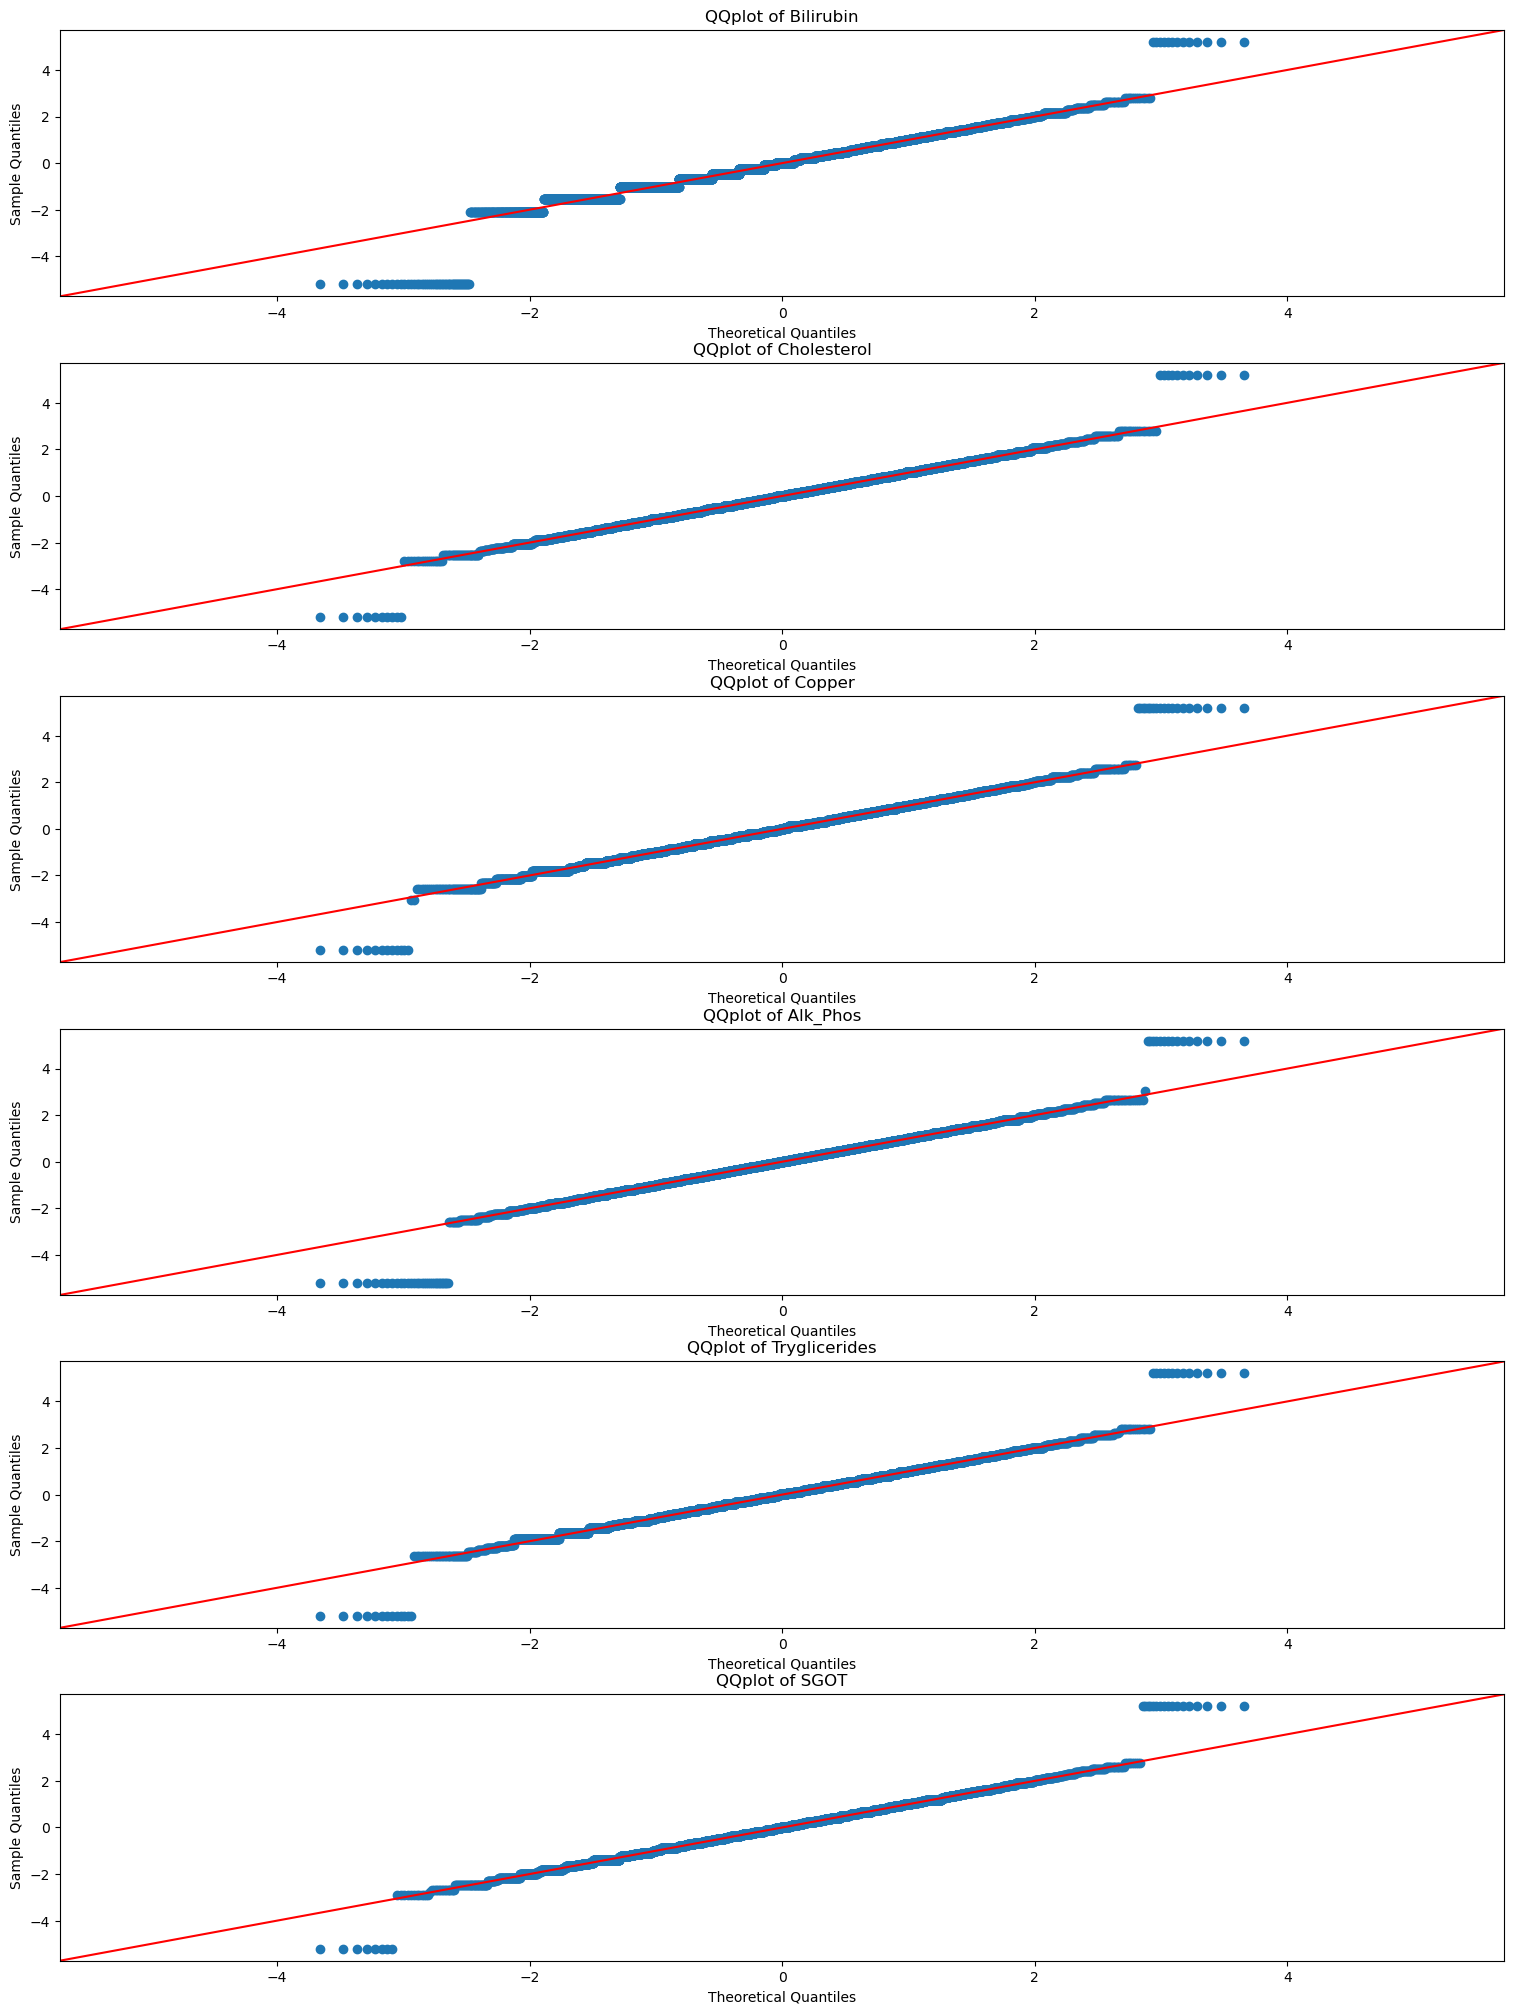

In [39]:
fig, axes = plt.subplots(6, 1, figsize =(15,20))
axes = np.ravel(axes)

for i, col in enumerate(df_transformed_qualtile.columns):
    qqplot(df_transformed_qualtile[col], line ='45', ax=axes[i])
    axes[i].set_title(f"QQplot of {col}")
plt.tight_layout(pad = 0.2)
plt.show()

#### Boxcox transformation

In [40]:
df_transformed_boxcox = df_train[cols_to_transform].copy()

In [41]:
for i, col in enumerate(df_transformed_boxcox.columns):
    transformed_data, _ = boxcox(df_transformed_boxcox[col]+0.0001)
    df_transformed_boxcox[col] = transformed_data

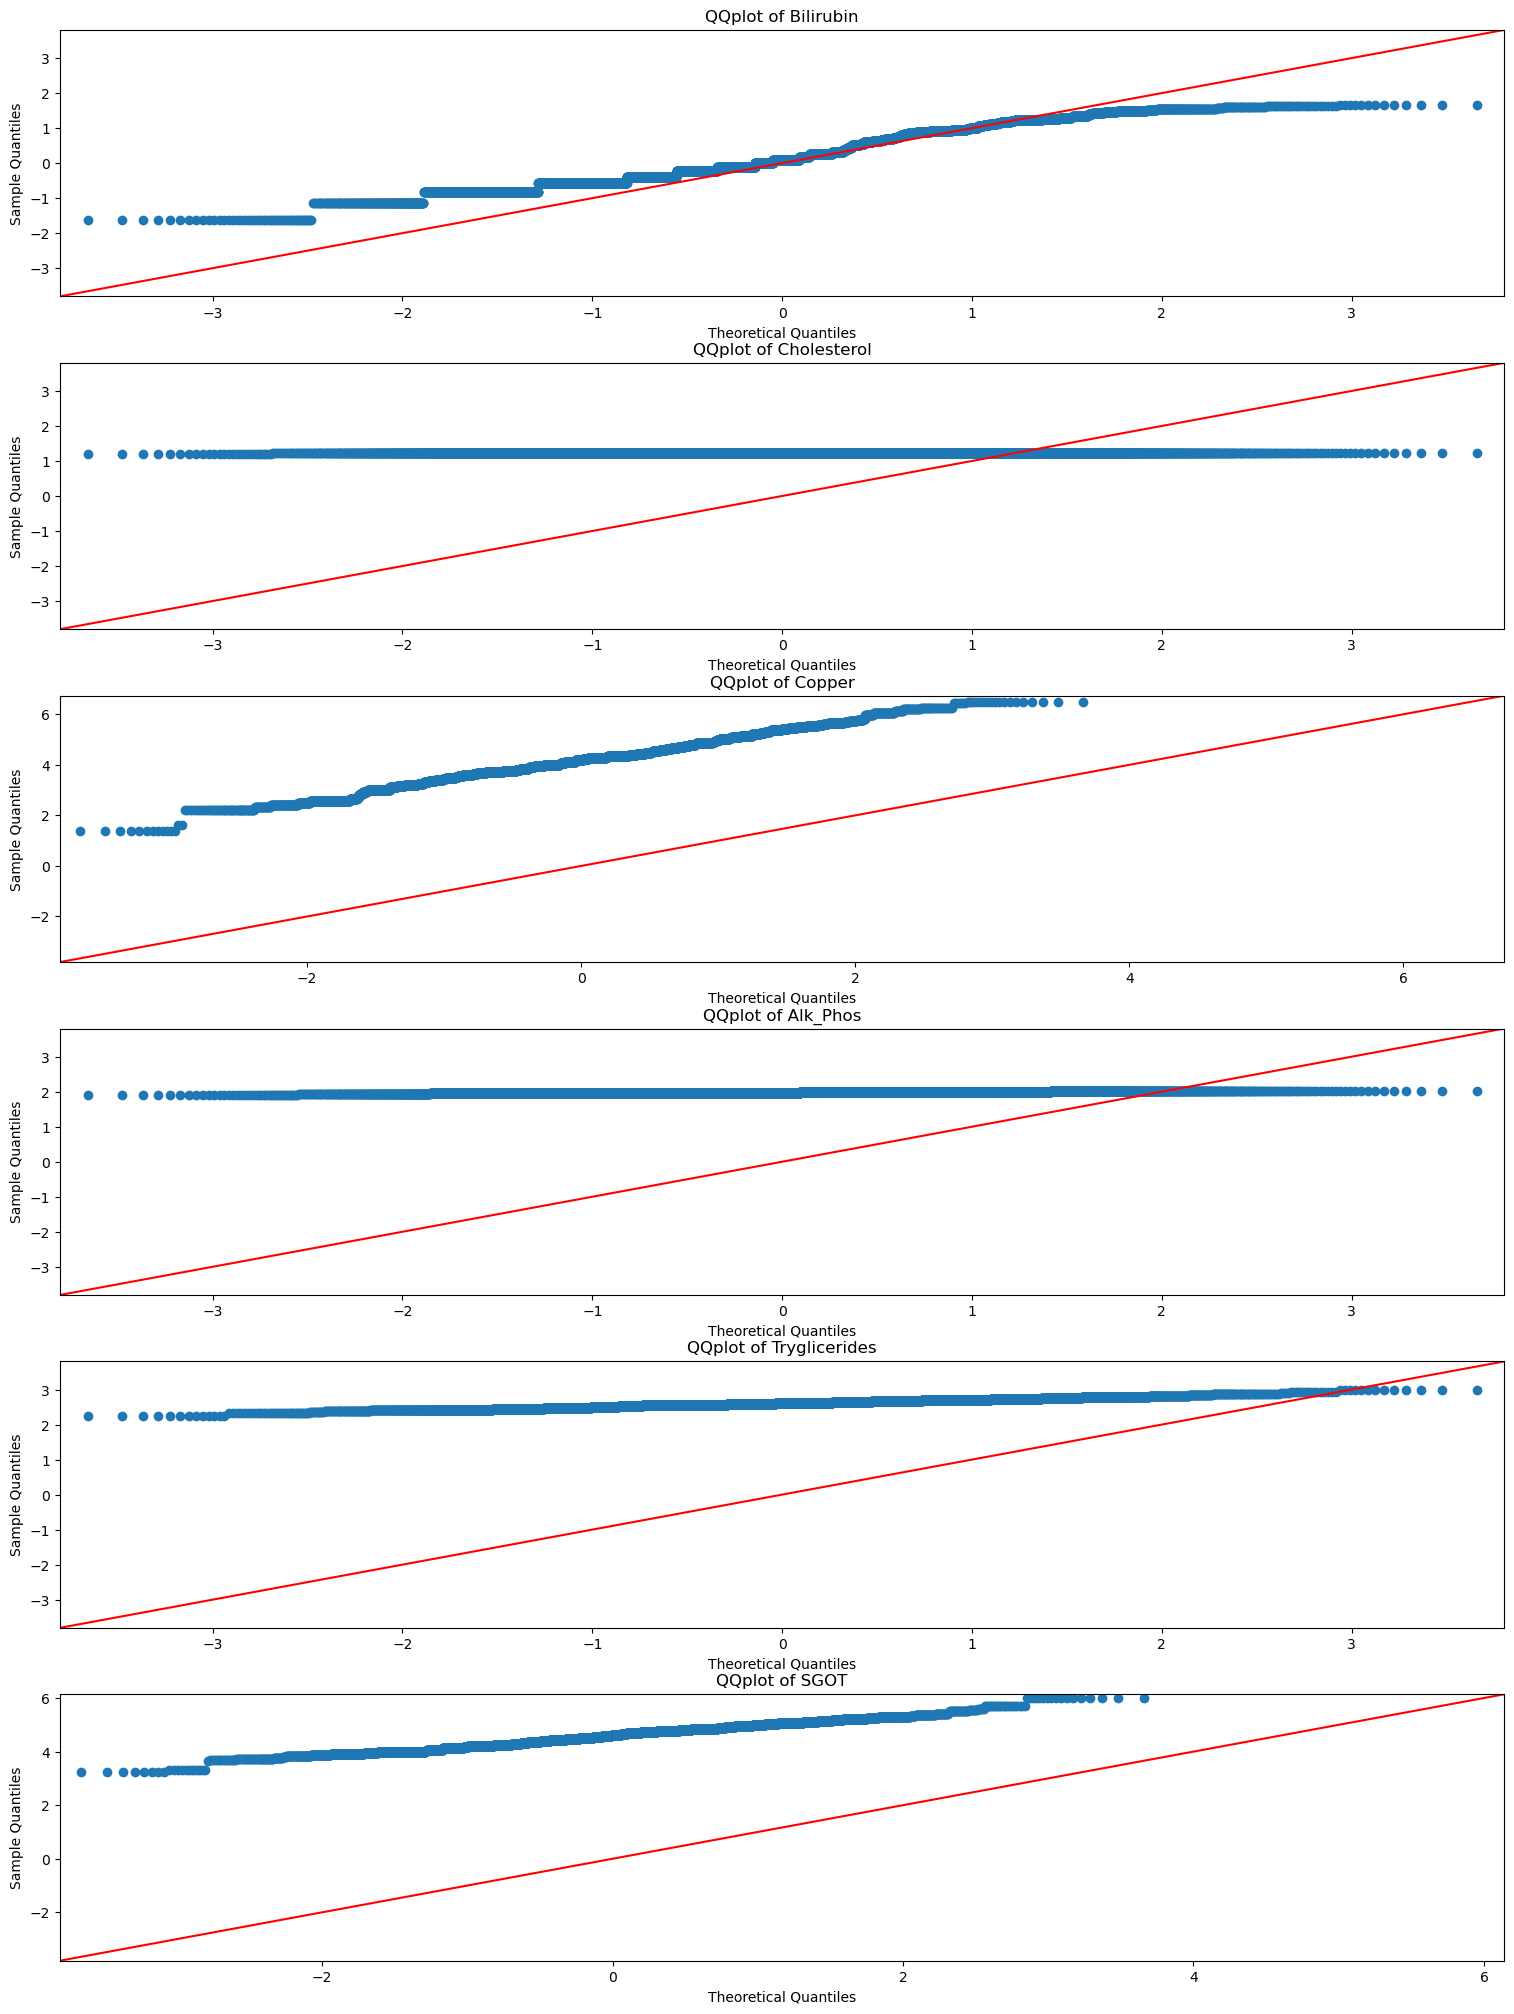

In [42]:
fig, axes = plt.subplots(6, 1, figsize =(15,20))
axes = np.ravel(axes)

for i, col in enumerate(df_transformed_boxcox.columns):
    qqplot(df_transformed_boxcox[col], line ='45', ax=axes[i])
    axes[i].set_title(f"QQplot of {col}")
plt.tight_layout(pad = 0.2)
plt.show()

### Encoding values

In [43]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()
one_hot_encoded = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"]
df_train_encoded = pd.get_dummies(df_train_copy, columns=one_hot_encoded, dtype=int)
df_test_encoded = pd.get_dummies(df_test_copy, columns=one_hot_encoded, dtype=int)

In [44]:
ordinal_encoder = OrdinalEncoder()
df_train_encoded['Stage'] = ordinal_encoder.fit_transform(df_train_encoded[['Stage']])
df_test_encoded['Stage'] = ordinal_encoder.transform(df_test_encoded[['Stage']])

In [45]:
label_encoder = LabelEncoder()
df_train_encoded[Label] = label_encoder.fit_transform(df_train_encoded[Label])

In [46]:
df_train_encoded.shape, df_test_encoded.shape

((7905, 27), (5271, 26))

In [47]:
df_train_encoded.columns

Index(['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status', 'Drug_D-penicillamine', 'Drug_Placebo', 'Sex_F',
       'Sex_M', 'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N', 'Hepatomegaly_Y',
       'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y'],
      dtype='object')

In [48]:
df_train_encoded.to_csv(os.path.join(data_folder, "train_encoded.csv"), index=False)
df_test_encoded.to_csv(os.path.join(data_folder, "test_encoded.csv"), index=False)

In [49]:
df_train_encoded.head()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,0,999,59.0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,...,1,1,0,1,0,1,0,1,0,0
1,1,2574,53.0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,...,0,1,0,1,0,1,0,1,0,0
2,2,3428,38.0,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,...,0,1,0,0,1,0,1,0,0,1
3,3,2576,51.0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,...,0,1,0,1,0,1,0,1,0,0
4,4,788,46.0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,...,0,1,0,0,1,1,0,1,0,0


### Correlation between all features

<Axes: >

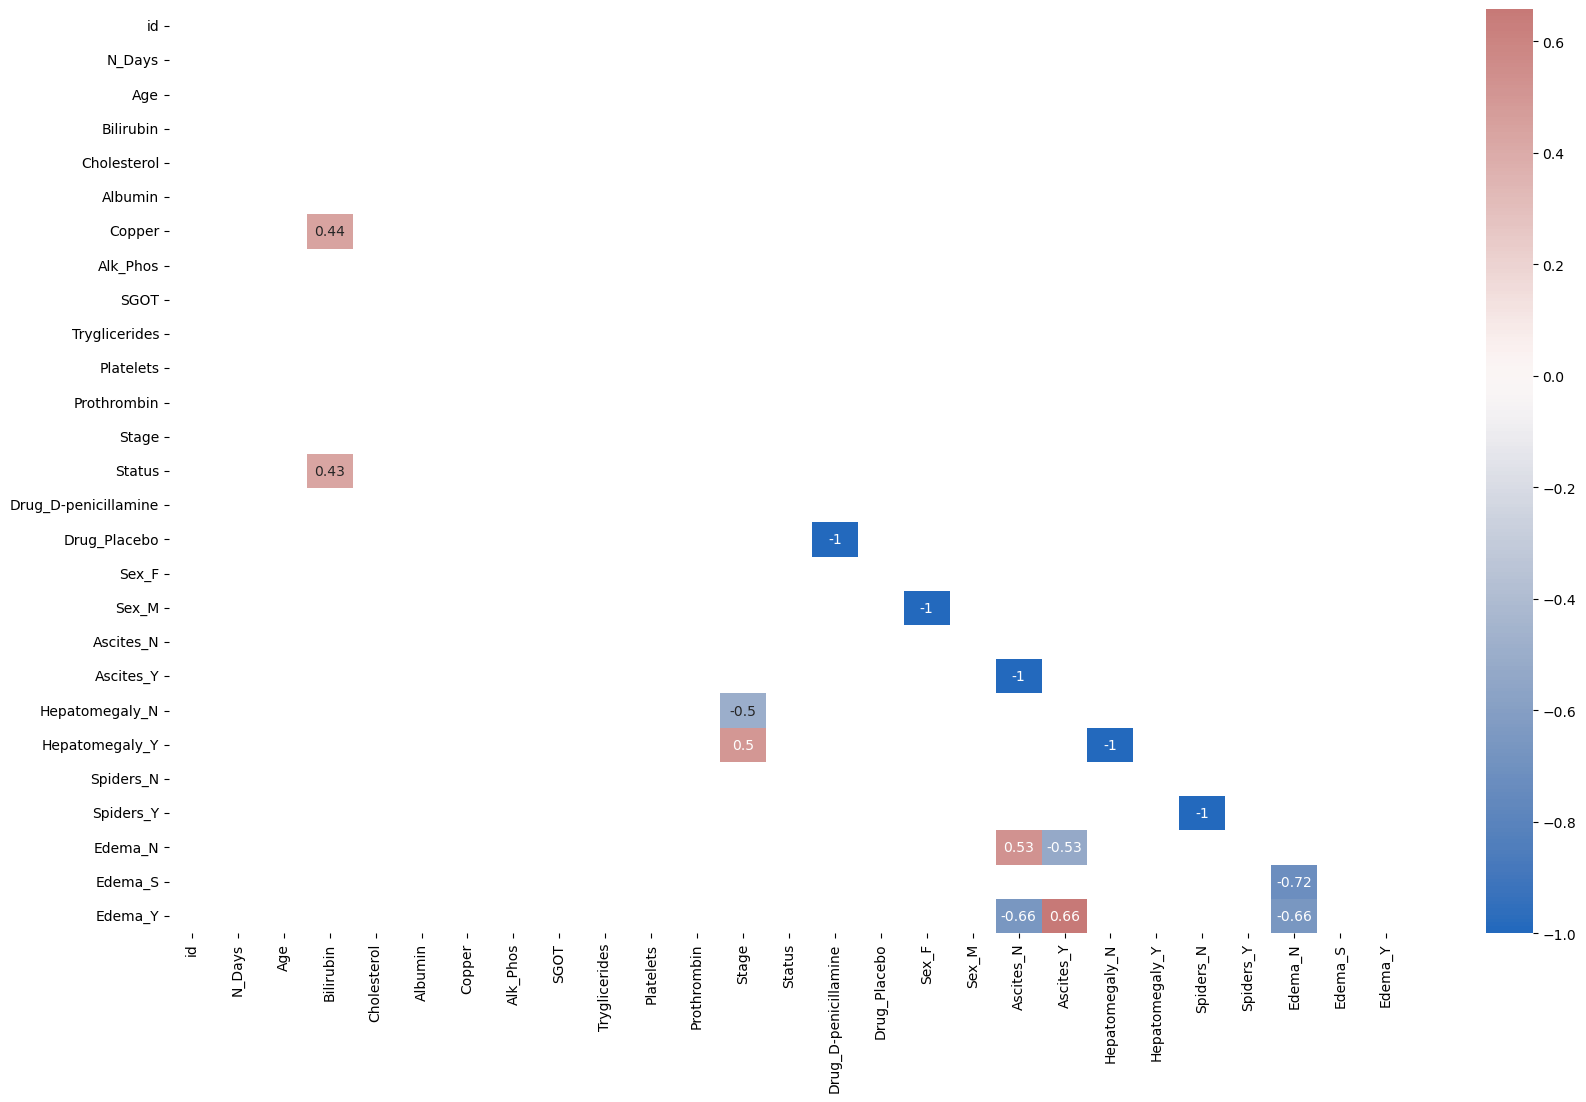

In [50]:
plt.figure(figsize=(20,12))
encoded_corr = df_train_encoded.corr()
encoded_corr = encoded_corr[(np.abs(encoded_corr)>0.4)]
matrix = np.triu(encoded_corr)
sns.heatmap(encoded_corr, annot=True,cmap="vlag", center=0, mask=matrix)

### PCA

In [51]:
scalor = StandardScaler()

In [52]:
scaled_train = scalor.fit_transform(df_train[num_feats])
df_scaled_train = pd.DataFrame(scaled_train)
df_scaled_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.942430,0.859239,-0.077237,-0.176908,-0.572940,1.160785,-0.113334,1.336304,-0.996442,1.472341,-1.189049
1,0.497025,0.263547,-0.444429,0.068784,-0.024043,-0.275420,-0.197909,0.414968,-0.520497,1.095026,0.474024
2,1.277529,-1.225685,0.185043,-0.263923,0.004846,0.620561,-0.413812,0.097266,-1.243933,-0.757248,1.369525


In [53]:
pca = PCA(n_components=5)
pca_data = pca.fit_transform(df_scaled_train)
pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])

In [54]:
pca.components_.shape

(5, 11)

In [55]:
pca.explained_variance_ratio_

array([0.25256261, 0.12638093, 0.09091219, 0.08446877, 0.0764544 ])

In [56]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

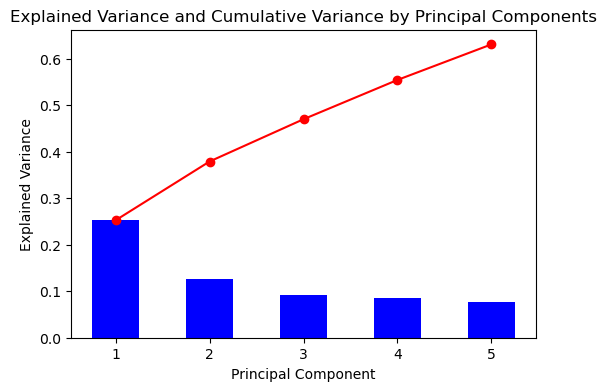

In [57]:
fig = plt.figure(figsize=(6, 4))
plt.bar(x= range(1, len(pca.explained_variance_ratio_) + 1), height=pca.explained_variance_ratio_, color='b', width=0.5)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Component')

plt.plot(range(1, len(exp_var_cumul)  + 1), exp_var_cumul, color='r', marker='o')

plt.title('Explained Variance and Cumulative Variance by Principal Components')
plt.show()

In [58]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'], index= num_feats)
loadings_df

,PCA1,PCA2,PCA3,PCA4,PCA5
N_Days,-0.571281,0.163952,0.279893,-0.077466,0.271831
Age,0.177454,-0.476933,0.402296,0.602482,-0.284985
Bilirubin,0.767435,0.034702,-0.020979,0.041582,0.041921
Cholesterol,0.462690,0.563045,-0.062565,0.030949,-0.136637
Albumin,-0.508788,0.278577,-0.018243,0.170697,0.452217
Copper,0.676466,-0.028768,-0.010417,0.073340,0.261022
Alk_Phos,0.255972,0.223336,0.776360,-0.291173,0.078862
SGOT,0.600015,0.245672,-0.105127,-0.320846,-0.208230
Tryglicerides,0.492296,0.306877,-0.102730,0.485797,0.389249
Platelets,-0.197405,0.598898,0.279222,0.254384,-0.281129


<Axes: >

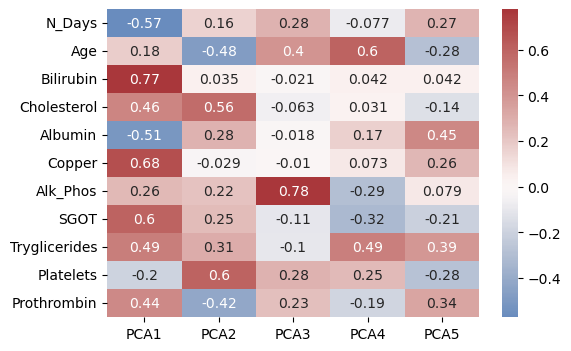

In [59]:
plt.figure(figsize=(6,4))
pca_corr = loadings_df.copy()
sns.heatmap(pca_corr, annot=True,cmap="vlag", center=0)

In [60]:
scalor_encoded = StandardScaler()

In [61]:
df_train_encoded[num_feats] = scalor_encoded.fit_transform(df_train_encoded[num_feats])
df_test_encoded[num_feats] = scalor_encoded.transform(df_test_encoded[num_feats])

In [62]:
df_train_encoded.to_csv(os.path.join(data_folder, "train_encoded_scaled.csv"), index=False)
df_test_encoded.to_csv(os.path.join(data_folder, "test_encoded_scaled.csv"), index=False)

In [70]:
df_train_encoded.shape

(7905, 27)

In [63]:
num_feat_with_encoded = df_train_encoded.columns.to_list()
num_feat_with_encoded.remove('Status')
num_feat_with_encoded.remove("id")

In [64]:
pca_encoded = PCA(n_components=5)
pca_data_encoded = pca_encoded.fit_transform(df_train_encoded[num_feat_with_encoded])
pca_df_encoded = pd.DataFrame(pca_data_encoded, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])

In [65]:
pca_encoded.explained_variance_ratio_

array([0.22858775, 0.1099952 , 0.07412999, 0.06993399, 0.06291985])

In [66]:
exp_var_cumul_enc = np.cumsum(pca_encoded.explained_variance_ratio_)

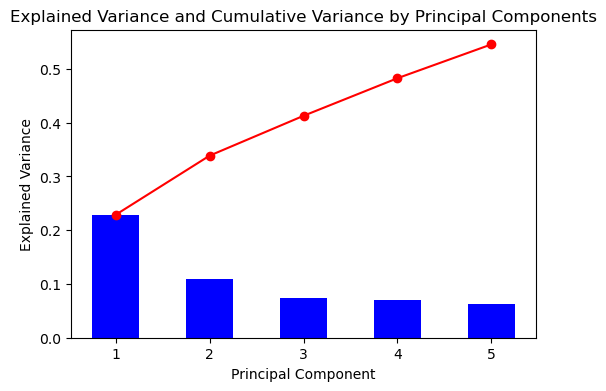

In [67]:
fig = plt.figure(figsize=(6, 4))
plt.bar(x= range(1, len(pca_encoded.explained_variance_ratio_) + 1), height=pca_encoded.explained_variance_ratio_, color='b', width=0.5)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Component')

plt.plot(range(1, len(exp_var_cumul_enc)  + 1), exp_var_cumul_enc, color='r', marker='o')

plt.title('Explained Variance and Cumulative Variance by Principal Components')
plt.show()

In [68]:
loadings_encoded = pca_encoded.components_.T * np.sqrt(pca_encoded.explained_variance_)
loadings_encoded_df = pd.DataFrame(loadings_encoded, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'], index= num_feat_with_encoded)
loadings_encoded_df

,PCA1,PCA2,PCA3,PCA4,PCA5
N_Days,-0.577930,0.088459,0.284827,-0.102802,0.276086
Age,0.201377,-0.412330,0.376324,0.683043,-0.251923
Bilirubin,0.746656,0.136569,-0.032392,0.069513,0.057900
Cholesterol,0.401909,0.603625,-0.043947,0.013125,-0.160551
Albumin,-0.531501,0.222127,-0.015320,0.117045,0.448525
Copper,0.662107,0.067193,-0.024963,0.106848,0.255669
Alk_Phos,0.243912,0.218753,0.786120,-0.280148,0.025026
SGOT,0.560376,0.322471,-0.101829,-0.265306,-0.241370
Tryglicerides,0.450101,0.373319,-0.108701,0.425151,0.408084
Platelets,-0.248800,0.552560,0.296522,0.194311,-0.165770


<Axes: >

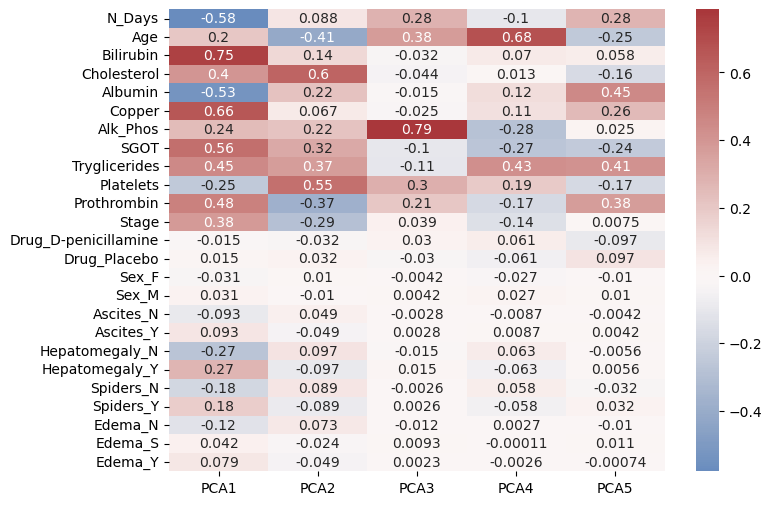

In [69]:
plt.figure(figsize=(8,6))
sns.heatmap(loadings_encoded_df, annot=True,cmap="vlag", center=0)